Импорт необходимых библиотек

In [2]:
!pip3 install -U pandas
import pandas as pd
import re
import csv
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
!pip install umap
import umap
!pip install sentencepiece
from gensim.models import Word2Vec
import pickle
!pip install umap-learn
import umap.umap_ as umap
from typing import List
from collections import Counter
from itertools import chain
from nltk.corpus import stopwords
import nltk
from pymystem3 import Mystem
from string import punctuation
from keras.preprocessing.sequence import pad_sequences
from sklearn import metrics

Предобработка получившегося датасета

In [3]:
df = pd.read_csv('/content/films_2.csv')
df.tail(10)

,Категория,Страна,Оценка зрителей,Оценка сайта,Оценка IMDb,Год выхода,Описание
2953,мультфильмы,США,8.3,6,5.8,2013,"Индюк Реджи вырос на обычной ферме, его жизнь ..."
2954,мультфильмы,США,8.2,0,7.1,1970,В аристократическом доме в Париже живет мама-к...
2955,мультфильмы,США,8.2,8,6.5,2012,И опять Белка со своим орехом расколола земной...
2956,мультфильмы,США,8.2,0,7.5,1973,"Добро пожаловать в дремучий Шервудский лес, гд..."
2957,мультфильмы,США,8.2,0,7.2,1981,"Добро пожаловать в дремучий Шервудский лес, гд..."
2958,приключения,США,8.2,0,6.0,2002,"Добро пожаловать в дремучий Шервудский лес, гд..."
2959,мультфильмы,США,8.1,6,6.7,2007,Команда пингвинов-документалистов приглашает з...
2960,мультфильмы,США,8.1,0,6.7,1977,Команда пингвинов-документалистов приглашает з...
2961,мультфильмы,США,8.1,0,7.5,1982,Скромная мышка становится героиней поневоле. Б...
2962,мультфильмы,США,8.1,0,6.4,2004,Скромная мышка становится героиней поневоле. Б...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963 entries, 0 to 2962
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Категория        2963 non-null   object 
 1   Страна           2963 non-null   object 
 2   Оценка зрителей  2963 non-null   float64
 3   Оценка сайта     2963 non-null   int64  
 4   Оценка IMDb      2963 non-null   float64
 5   Год выхода       2963 non-null   int64  
 6   Описание         2959 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 162.2+ KB


In [5]:
#Удаляем дубликаты
df = df.drop_duplicates()
print("Датасет после удаления дубликатов:")
df.info()

Датасет после удаления дубликатов:
<class 'pandas.core.frame.DataFrame'>
Index: 2585 entries, 0 to 2962
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Категория        2585 non-null   object 
 1   Страна           2585 non-null   object 
 2   Оценка зрителей  2585 non-null   float64
 3   Оценка сайта     2585 non-null   int64  
 4   Оценка IMDb      2585 non-null   float64
 5   Год выхода       2585 non-null   int64  
 6   Описание         2581 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 161.6+ KB


In [6]:
# Нормализация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[["Оценка зрителей", "Оценка сайта", "Оценка IMDb","Год выхода"]])

# Применение DBSCAN для удаления выборосов
dbscan = DBSCAN(eps=0.5, min_samples=2)
df['cluster'] = dbscan.fit_predict(scaled_data)
df = df[df['cluster'] != -1]
print(df)
df.info()
new_df = df.drop(['cluster'], axis='columns')

            Категория  Страна  Оценка зрителей  Оценка сайта  Оценка IMDb  \
0              драма   Россия              6.5             6          6.3   
1     биографический   Россия              4.7             7          5.9   
2              драма   Россия              5.7             8          7.6   
3            комедия   Россия              6.8             0          6.4   
4           детектив   Россия              6.2             6          6.0   
...               ...     ...              ...           ...          ...   
2958     приключения      США              8.2             0          6.0   
2959     мультфильмы      США              8.1             6          6.7   
2960     мультфильмы      США              8.1             0          6.7   
2961     мультфильмы      США              8.1             0          7.5   
2962     мультфильмы      США              8.1             0          6.4   

      Год выхода                                           Описание  cluste

In [7]:
#Очищаем выборку
category = new_df.value_counts('Категория')
#print(category)
new_df = new_df[(new_df['Категория'] != 'драм') & (new_df['Категория'] != 'комеди') & (new_df['Категория'] != 'документальны') & (new_df['Категория'] != 'мультфильм')  & (new_df['Категория'] != 'для взрослы')  & (new_df['Категория'] != 'боеви')  &  (new_df['Категория'] != 'трилле')]

countries = new_df.value_counts('Страна')
#print(countries)
new_df = new_df[(new_df['Страна'] != 'елодрама') & (new_df['Страна'] != 'Южная  Корея')]

years = new_df.value_counts('Год выхода')
#print(years)
new_df = new_df[(new_df['Год выхода'] >= 1900) & (new_df['Год выхода'] <= 2023)]


In [8]:
print(new_df.shape)

(2430, 7)


Уменьшаем размер датасета для дальнейшего удобства работы, соблюдая ограничение в кол-во записей (мин 1000)

In [9]:
new_df2 = new_df.head(1025)
print(len(new_df2))

1025


Предочищаем текст описаний фильмов

In [10]:
import pandas as pd
import nltk
import re

def clean_text(text):
    # Удаление всех символов, кроме букв и пробелов
    text = re.sub(r'[^А-Яа-яЁёa-zA-Zs]', ' ', str(text))
    text = re.sub(r's+', ' ', text)
    text = re.sub(r's+', ' ', text).strip()
    text = text.lower()
    return text


new_df2['cleaned_description'] = new_df2['Описание'].apply(clean_text)
# Удаляем строки с пустыми описаниями
new_df2 = new_df2[new_df2['cleaned_description'].str.strip().astype(bool)]
print(new_df2[['Оценка зрителей', 'cleaned_description']].head())

print(new_df2.shape)

   Оценка зрителей                                cleaned_description
2              5.7  казань  перестроечные времена  школьник андрей...
3              6.8  чак  денис васильев   фил  влад коноплев   мас...
4              6.2  наступает лето  а значит  пора отправляться в ...
5              6.6  в разгар президентской гонки  голосуй или прои...
6              5.4  многосерийный проект показывает основные вехи ...
(1004, 8)


<ipython-input-10-ef3f23108c2e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df2['cleaned_description'] = new_df2['Описание'].apply(clean_text)


Немного изучим состав текстов, преобразовав их в вектора

In [11]:
descrips = new_df2['cleaned_description'].tolist()
print(len(descrips))
descrips[:6]

1004


['казань  перестроечные времена  школьник андрей  леон кемстач  растет без отца и живет с младшей сестрой и мамой  юлия александрова   подросток хорошо учится и играет на фортепьяно  однажды в троллейбусе гопник марат  рузиль минекаев  отнимает у андрея часы  а через несколько дней подростки снова сталкиваются в школе  учительница английского просит андрея подтянуть отстающего ученика   как раз марата  вскоре парни становятся друзьями  и пианист по примеру нового товарища вступает в молодежную преступную группировку  андрей учится жить в рамках строгой иерархической системы  банда становится активнее и опаснее  когда из афганистана возвращается сводный брат марата вова по кличке адидас  иван янковский',
 'чак  денис васильев   фил  влад коноплев   масса  савелий наумов  и вжик  ярослав заргаров    четверо приятелей бандитов  орудующих в конце лихих девяностых  очередной налет с целью выбить деньги из должника неожиданно заканчивается для них попаданием в криокамеру  когда цикл заморозк

<Axes: >

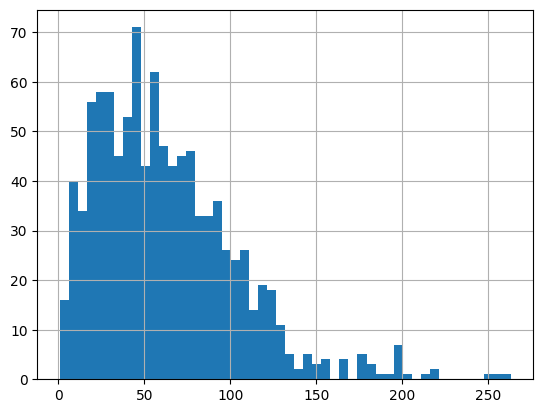

In [12]:
#посмотрим, сколько слов в текстах
words = new_df2['cleaned_description'].apply(lambda text: len(text.split()))
words.hist(bins=50)

Можно сделать вывод о том, что сами описания не очень большие, в основном содержат до 50 слов

In [13]:
#сформируем векторы и "объединим" схожие группы с помощью CBOW
sentences = [descrip.split() for descrip in descrips]
model = Word2Vec(sentences=sentences,
                 sg=False,  # cbow model
                 vector_size=100,
                 window=5,
                 seed=42,
                 epochs=20,
                 min_count=1,
                 )
print('Размерность получившихся векторов слов:', model.wv.vectors.shape)

Размерность получившихся векторов слов: (18686, 100)


In [14]:
points = umap.UMAP(random_state=42).fit_transform(model.wv.vectors)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


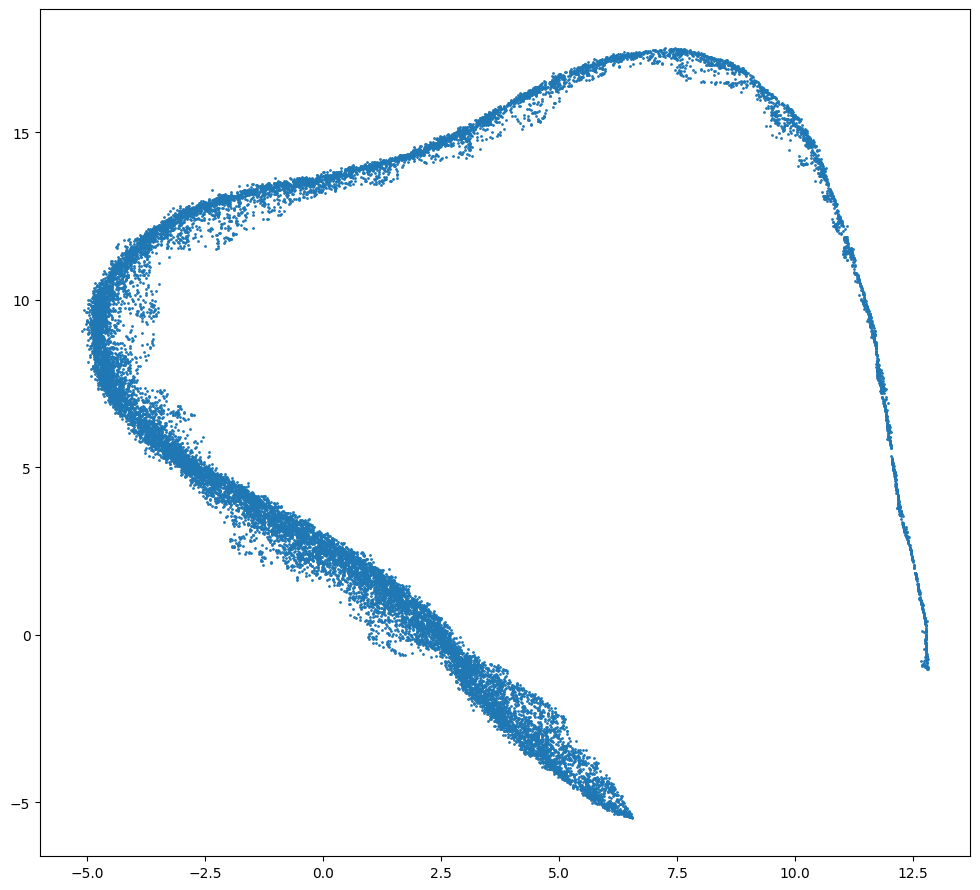

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], s=1) #получился симпатичный червячок:)

Теперь перейдем уже к формированию словаря и эмбедингов

In [16]:
def build_vocab(texts: List[str]) -> Counter:  #примитивным методом формируем исходный словарь
    words = list(chain.from_iterable([text.split() for text in texts]))
    vocab = Counter(words)
    return vocab

In [17]:
texts = new_df2.cleaned_description.tolist()
vocab = build_vocab(texts)
print(len(vocab))

sorted(list(vocab.items()), key=lambda p: -p[1])[:30]

18686


[('и', 2411),
 ('в', 2344),
 ('на', 950),
 ('с', 726),
 ('не', 670),
 ('что', 525),
 ('но', 473),
 ('из', 428),
 ('его', 409),
 ('он', 396),
 ('за', 318),
 ('по', 310),
 ('а', 295),
 ('к', 284),
 ('о', 279),
 ('как', 251),
 ('она', 228),
 ('для', 220),
 ('от', 214),
 ('все', 209),
 ('у', 188),
 ('это', 183),
 ('они', 178),
 ('чтобы', 174),
 ('то', 170),
 ('их', 159),
 ('который', 152),
 ('время', 148),
 ('после', 141),
 ('жизни', 130)]

In [18]:
#с помощью удаления стоп-слов русского языка и лемматизация чистим и сокращаем размер словаря
nltk.download('stopwords')
mystem = Mystem()
rus_stopwords = stopwords.words('russian')

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in rus_stopwords\
              and token != " " \
              and token.strip() not in punctuation]

    text = " ".join(tokens)

    return text

new_df2['cleaned_description'] = new_df2['cleaned_description'].apply(preprocess_text)
print(new_df2[['Оценка зрителей', 'cleaned_description']].head())
print(new_df2.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


   Оценка зрителей                                cleaned_description
2              5.7  казань перестроечный время школьник андрей лео...
3              6.8  чак денис васильев фил влад коноплев масса сав...
4              6.2  наступать лето значит пора отправляться лагерь...
5              6.6  разгар президентский гонка голосовать проигрыв...
6              5.4  многосерийный проект показывать основной веха ...
(1004, 8)


In [19]:
texts2 = new_df2.cleaned_description.tolist()
vocab2 = build_vocab(texts2)
print(len(vocab2))

sorted(list(vocab2.items()), key=lambda p: -p[1])[:30]


10358


[('который', 569),
 ('свой', 504),
 ('жизнь', 269),
 ('друг', 252),
 ('год', 251),
 ('становиться', 243),
 ('весь', 239),
 ('время', 225),
 ('человек', 208),
 ('новый', 204),
 ('это', 203),
 ('фильм', 165),
 ('история', 159),
 ('самый', 152),
 ('девушка', 150),
 ('оказываться', 148),
 ('мочь', 145),
 ('герой', 140),
 ('мир', 132),
 ('женщина', 130),
 ('дело', 119),
 ('жить', 109),
 ('семья', 107),
 ('дом', 102),
 ('решать', 99),
 ('начинать', 98),
 ('молодой', 97),
 ('находить', 96),
 ('вместе', 93),
 ('пытаться', 92)]

Можно заметить, что словарь уже стал на 8к слов меньше

In [20]:
#теперь еще удалим стоп-слова корпуса, возьмем первые 10
vocab2.most_common(10)

[('который', 569),
 ('свой', 504),
 ('жизнь', 269),
 ('друг', 252),
 ('год', 251),
 ('становиться', 243),
 ('весь', 239),
 ('время', 225),
 ('человек', 208),
 ('новый', 204)]

In [21]:
for word, freq in vocab2.most_common(10):
    if word in vocab2:
        vocab2.pop(word)

vocab2.most_common(30)

[('это', 203),
 ('фильм', 165),
 ('история', 159),
 ('самый', 152),
 ('девушка', 150),
 ('оказываться', 148),
 ('мочь', 145),
 ('герой', 140),
 ('мир', 132),
 ('женщина', 130),
 ('дело', 119),
 ('жить', 109),
 ('семья', 107),
 ('дом', 102),
 ('решать', 99),
 ('начинать', 98),
 ('молодой', 97),
 ('находить', 96),
 ('вместе', 93),
 ('пытаться', 92),
 ('отправляться', 90),
 ('любовь', 90),
 ('главный', 88),
 ('город', 81),
 ('каждый', 75),
 ('помогать', 75),
 ('хороший', 75),
 ('ребенок', 75),
 ('день', 74),
 ('убийство', 74)]

In [22]:
print(len(vocab2))

10348


Применим BPE, чтобы еще больше сократить словарь (соблюсти ограничение в макс кол-во слов = 10к)

In [23]:
# Разделение на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_df2['cleaned_description'], new_df2['Оценка зрителей'], test_size=0.2, random_state=42)
print(f'Размеры выборок: Обучающая: {X_train.shape} Тестовая: {X_test.shape}')

Размеры выборок: Обучающая: (803,) Тестовая: (201,)


In [24]:
def clean_text(text):
    #удаляем лишние пробелы, если они еще остались
    return re.sub(r's+', ' ', text).strip()


def get_vocab(texts, num_merges):
    vocab = Counter()
    for text in texts:
        words = clean_text(text).split()
        for word in words:
            vocab[word] += 1

    pairs = Counter()
    for word, freq in vocab.items():
        symbols = list(word)
        for i in range(len(symbols) - 1):
            pairs[(symbols[i], symbols[i + 1])] += freq

    for _ in range(num_merges):
        if not pairs:
            break
        best_pair = pairs.most_common(1)[0][0]
        new_symbol = ''.join(best_pair)

        # Обновляем словарь
        new_vocab = {}
        for word in vocab:
            new_word = word.replace(best_pair[0] + best_pair[1], new_symbol)
            new_vocab[new_word] = vocab[word]

        vocab = Counter(new_vocab)

        pairs = Counter()
        for word, freq in vocab.items():
            symbols = list(word)
            for i in range(len(symbols) - 1):
                pairs[(symbols[i], symbols[i + 1])] += freq

    return vocab


num_merges = 10000  # Количество объединений пар ака размер словаря
vocab = get_vocab(X_train, num_merges)

# Создаем токенизатор на основе полученного словаря
tokenizer = {word: idx + 1 for idx, (word, _) in enumerate(vocab.items())}

# Преобразование текста в последовательности индексов
X_train_seq = [[tokenizer.get(word, 0) for word in clean_text(text).split()] for text in X_train]
X_test_seq = [[tokenizer.get(word, 0) for word in clean_text(text).split()] for text in X_test]

# Паддинг последовательностей
max_length = max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_test_seq))
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')


vocab_size = len(tokenizer) + 1
print(f'Размер словаря: {vocab_size}')

Размер словаря: 9288


Постановка задачи, выделение таргета

In [25]:
# Пусть задача звучит как: "Предскажи оценку зрителей для следующего фильма на основе его описания", и является задачей регрессии
texts2 = new_df2['cleaned_description'].tolist()
ratings2 = new_df2['Оценка зрителей'].tolist()

По сути данные уже размечены - мы имеем конкретные метки (оценки) для каждого из фильмов в датасете, и теперь попробуем предсказать их на основе описаний

Реализация DL модели (nn.Embedding + nn.LSTM + nn.Linear слои)

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim

class MovieRatingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(MovieRatingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = hn[-1]
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x

# Инициализация модели
embedding_dim = 100
hidden_dim = 64
model = MovieRatingModel(vocab_size, embedding_dim, hidden_dim)


Обучение модели

Epoch 1/10, Loss: 1.4004757404327393
Epoch 2/10, Loss: 0.8397526741027832
Epoch 3/10, Loss: 0.35778146982192993
Epoch 4/10, Loss: -0.19366958737373352
Epoch 5/10, Loss: -0.6932159662246704
Epoch 6/10, Loss: -1.1355292797088623
Epoch 7/10, Loss: -1.7718136310577393
Epoch 8/10, Loss: -2.015880584716797
Epoch 9/10, Loss: -2.9596285820007324
Epoch 10/10, Loss: -3.2583394050598145
ROC AUC Train: 0.7269423558897243, ROC AUC Test: 0.4849246231155779


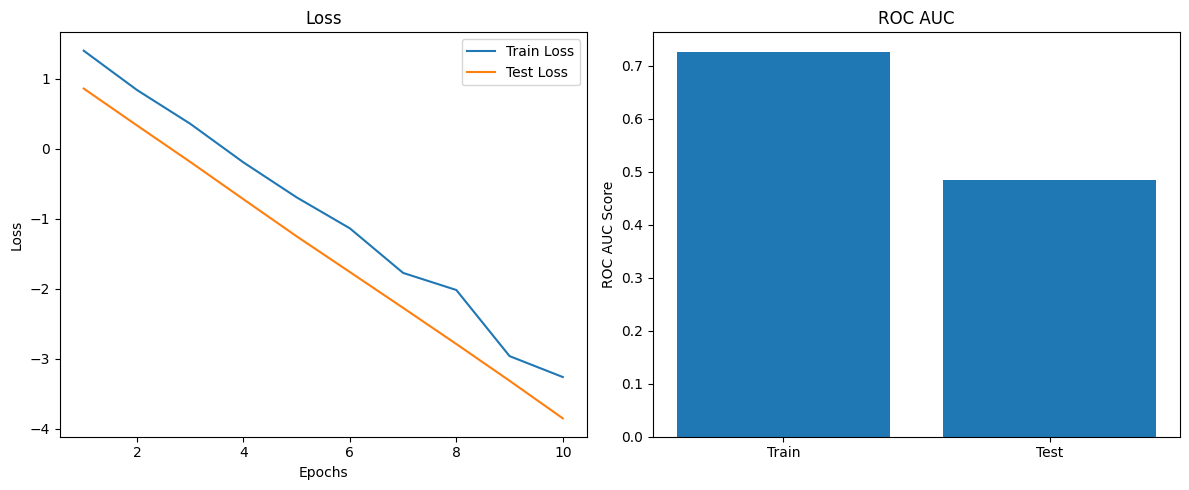

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import metrics

# Параметры обучения
num_epochs = 10
batch_size = 32
learning_rate = 0.001

train_losses = []
test_losses = []

# Оптимизатор и функция потерь
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Переводим данные в тензоры
X_train_tensor = torch.tensor(X_train_padded).long()
y_train_tensor = torch.tensor(y_train.values).float().view(-1, 1)
X_test_tensor = torch.tensor(X_test_padded).long()
y_test_tensor = torch.tensor(y_test.values).float().view(-1, 1)


for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

    # Оценка на тестовой выборке
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

# Вычисление ROC AUC
y_train_pred_prob = torch.sigmoid(outputs).detach().numpy()
y_test_pred_prob = torch.sigmoid(test_outputs).detach().numpy()

# Преобразование в одномерные массивы
y_train_true = y_train_tensor.numpy().flatten()
y_test_true = y_test_tensor.numpy().flatten()

# Преобразование y_train_true и y_test_true в двоичные метки (0 или 1)
y_train_true_binary = (y_train_true > 0.5).astype(int)
y_test_true_binary = (y_test_true > 0.5).astype(int)

roc_auc_train = metrics.roc_auc_score(y_train_true_binary, y_train_pred_prob)
roc_auc_test = metrics.roc_auc_score(y_test_true_binary, y_test_pred_prob)

print(f'ROC AUC Train: {roc_auc_train}, ROC AUC Test: {roc_auc_test}')

# Построение графиков
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График ROC AUC
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Test'], [roc_auc_train, roc_auc_test])
plt.title('ROC AUC')
plt.ylabel('ROC AUC Score')

plt.tight_layout()
plt.show()

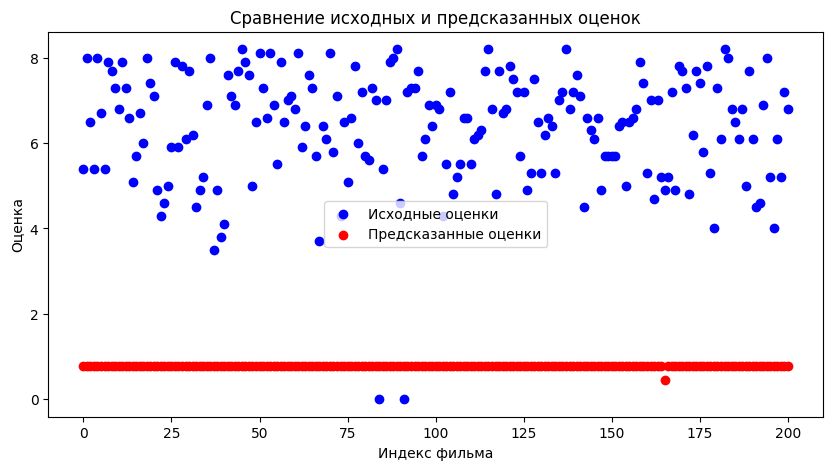

In [55]:
# Получение предсказаний на тестовой выборке
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)

# Визуализация исходных оценок и предсказанных оценок
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Исходные оценки')
plt.scatter(range(len(test_outputs)), test_outputs, color='red', label='Предсказанные оценки')
plt.xlabel('Индекс фильма')
plt.ylabel('Оценка')
plt.title('Сравнение исходных и предсказанных оценок')
plt.legend()
plt.show()

Настройка модели (подбор гиперпараметров и тд)

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
!pip install optuna
import optuna
from sklearn import metrics

class MovieRatingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout1, dropout2):
        super(MovieRatingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        #self.dropout2 = nn.Dropout(dropout2)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = hn[-1]
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        #x = self.dropout2(x)
        return x

def train_and_evaluate(trial):
    # Гиперпараметры
    embedding_dim = trial.suggest_int('embedding_dim',100,200)
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128, 64)
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.5)
    #dropout2 = trial.suggest_float('dropout2', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    # Инициализация модели
    model = MovieRatingModel(vocab_size, embedding_dim, hidden_dim, dropout1)#, dropout2)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Переводим данные в тензоры
    X_train_tensor = torch.tensor(X_train_padded).long()
    y_train_tensor = torch.tensor(y_train.values).float().view(-1, 1)


    for epoch in range(10):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_padded).long()
        y_test_tensor = torch.tensor(y_test.values).float().view(-1, 1)

        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)

        # Вычисление ROC AUC
        y_test_pred_prob = torch.sigmoid(test_outputs).detach().numpy().flatten()
        y_test_true_binary = (y_test_tensor.numpy().flatten() > 0.5).astype(int)

        roc_auc = metrics.roc_auc_score(y_test_true_binary, y_test_pred_prob)

    return roc_auc

# Оптимизация с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(train_and_evaluate, n_trials=50)

print("Best hyperparameters: ", study.best_params)
print("Best ROC AUC: ", study.best_value)

[I 2024-12-09 16:49:08,787] A new study created in memory with name: no-name-68edc5cd-c510-4d6c-bbcf-cb2c79e93366
<ipython-input-47-e72ae58e0ccb>:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  embedding_dim = trial.suggest_int('embedding_dim', 50,100,200)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [50, 100] and step=200, but the range is not divisible by `step`. It will be replaced by [50, 50].
  warnings.warn(
<ipython-input-47-e72ae58e0ccb>:32: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_dim = trial.suggest_int('hidden_dim', 32, 128, 64)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [32, 128] and step=64, but the range is not divisible by `step`. It will be replaced by [32, 96].

Best hyperparameters:  {'embedding_dim': 50, 'hidden_dim': 32, 'dropout1': 0.3029010263810406, 'dropout2': 0.1179074413967553, 'learning_rate': 0.00019422545600099826}
Best ROC AUC:  0.6570351758793971


Добавлены batchnorm-слои и изменены значения гиперпараметров

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import metrics

class MovieRatingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(MovieRatingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim // 2)  # BatchNorm для первого скрытого слоя
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = hn[-1]
        x = self.fc1(x)
        x = self.batchnorm1(x)  # Применяем BatchNorm
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x


# Инициализация модели
embedding_dim = 50
hidden_dim = 32
model = MovieRatingModel(vocab_size, embedding_dim, hidden_dim)

Epoch 1/20, Loss: -0.34716519713401794
Epoch 2/20, Loss: -0.4526704251766205
Epoch 3/20, Loss: -0.5393024682998657
Epoch 4/20, Loss: -0.600093424320221
Epoch 5/20, Loss: -0.668388307094574
Epoch 6/20, Loss: -0.5476314425468445
Epoch 7/20, Loss: -0.5438875555992126
Epoch 8/20, Loss: -0.6037839651107788
Epoch 9/20, Loss: -0.5313742160797119
Epoch 10/20, Loss: -0.6160589456558228
Epoch 11/20, Loss: -0.6155434846878052
Epoch 12/20, Loss: -0.5781903266906738
Epoch 13/20, Loss: -0.649728000164032
Epoch 14/20, Loss: -0.6807126998901367
Epoch 15/20, Loss: -0.812576949596405
Epoch 16/20, Loss: -0.7718575596809387
Epoch 17/20, Loss: -0.7064908146858215
Epoch 18/20, Loss: -0.8071849346160889
Epoch 19/20, Loss: -0.7960570454597473
Epoch 20/20, Loss: -0.7100821137428284
ROC AUC Train: 0.7156641604010024, ROC AUC Test: 0.5301507537688442


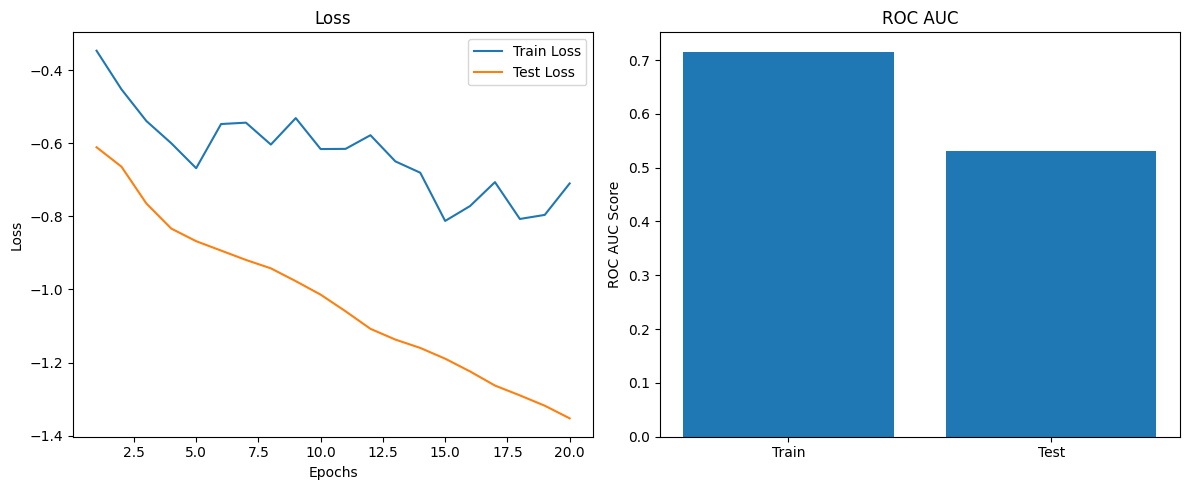

In [105]:
# Параметры обучения
num_epochs = 20
batch_size = 32
learning_rate = 0.001

train_losses = []
test_losses = []

# Оптимизатор и функция потерь
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Переводим данные в тензоры
X_train_tensor = torch.tensor(X_train_padded).long()
y_train_tensor = torch.tensor(y_train.values).float().view(-1, 1)
X_test_tensor = torch.tensor(X_test_padded).long()
y_test_tensor = torch.tensor(y_test.values).float().view(-1, 1)


for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()


    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

    # Оценка на тестовой выборке
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

# Вычисление ROC AUC
y_train_pred_prob = torch.sigmoid(outputs).detach().numpy()
y_test_pred_prob = torch.sigmoid(test_outputs).detach().numpy()

# Преобразование в одномерные массивы
y_train_true = y_train_tensor.numpy().flatten()
y_test_true = y_test_tensor.numpy().flatten()

# Преобразование y_train_true и y_test_true в двоичные метки (0 или 1)
y_train_true_binary = (y_train_true > 0.5).astype(int)
y_test_true_binary = (y_test_true > 0.5).astype(int)

roc_auc_train = metrics.roc_auc_score(y_train_true_binary, y_train_pred_prob)
roc_auc_test = metrics.roc_auc_score(y_test_true_binary, y_test_pred_prob)

print(f'ROC AUC Train: {roc_auc_train}, ROC AUC Test: {roc_auc_test}')


plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График ROC AUC
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Test'], [roc_auc_train, roc_auc_test])
plt.title('ROC AUC')
plt.ylabel('ROC AUC Score')

plt.tight_layout()
plt.show()


Несмотря на то, то результат достаточно нехороший (почти рандомный  - 0.5), это пока что лучшее, что вышло

In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
import numpy as np


class MovieRatingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout1, dropout2):
        super(MovieRatingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        self.dropout2 = nn.Dropout(dropout2)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = hn[-1]
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x

# Функция для оценки модели
def evaluate_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs=10):
    train_losses = []
    val_losses = []
    roc_auc_train = []
    roc_auc_val = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Обучение
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Валидация
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor)
            val_losses.append(val_loss.item())

            # ROC AUC
            y_train_pred_prob = torch.sigmoid(outputs).detach().numpy()
            y_val_pred_prob = torch.sigmoid(val_outputs).detach().numpy()

            # Преобразуем в одномерные массивы
            y_train_true = y_train_tensor.numpy().flatten()
            y_val_true = y_val_tensor.numpy().flatten()

            # Преобразование y_train_true и y_test_true в двоичные метки (0 или 1)
            y_train_true_binary = (y_train_true > 0.5).astype(int)
            y_test_true_binary = (y_test_true > 0.5).astype(int)

            roc_auc_train.append(metrics.roc_auc_score(y_train_true_binary, y_train_pred_prob))
            roc_auc_val.append(metrics.roc_auc_score(y_test_true_binary, y_test_pred_prob))


    return train_losses, val_losses, roc_auc_train, roc_auc_val

# Перебор гиперпараметров с помощью Random Search
param_grid = {
    'embedding_dim': [50, 100, 200],
    'hidden_dim': [32, 64, 128],
    'dropout1': [0.3, 0.5],
    'dropout2': [0.1, 0.3],
    #'learning_rate': [0.001, 0.0005, 0.0001]
}

# Функция для выполнения random search
best_roc_auc_val = 0
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")

    # Инициализация модели
    model = MovieRatingModel(vocab_size, **params)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)


    train_losses, val_losses, roc_auc_train, roc_auc_val = evaluate_model(
        model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs=20
    )

    # Сохраняем наилучшие гиперпараметры по ROC AUC на валидационной выборке
    if roc_auc_val[-1] > best_roc_auc_val:
        best_roc_auc_val = roc_auc_val[-1]
        best_params = params

print(f"Best hyperparameters: {best_params}")


Training with parameters: {'dropout1': 0.3, 'dropout2': 0.1, 'embedding_dim': 50, 'hidden_dim': 32}
Training with parameters: {'dropout1': 0.3, 'dropout2': 0.1, 'embedding_dim': 50, 'hidden_dim': 64}
Training with parameters: {'dropout1': 0.3, 'dropout2': 0.1, 'embedding_dim': 50, 'hidden_dim': 128}
Training with parameters: {'dropout1': 0.3, 'dropout2': 0.1, 'embedding_dim': 100, 'hidden_dim': 32}
Training with parameters: {'dropout1': 0.3, 'dropout2': 0.1, 'embedding_dim': 100, 'hidden_dim': 64}
Training with parameters: {'dropout1': 0.3, 'dropout2': 0.1, 'embedding_dim': 100, 'hidden_dim': 128}
Training with parameters: {'dropout1': 0.3, 'dropout2': 0.1, 'embedding_dim': 200, 'hidden_dim': 32}
Training with parameters: {'dropout1': 0.3, 'dropout2': 0.1, 'embedding_dim': 200, 'hidden_dim': 64}
Training with parameters: {'dropout1': 0.3, 'dropout2': 0.1, 'embedding_dim': 200, 'hidden_dim': 128}
Training with parameters: {'dropout1': 0.3, 'dropout2': 0.3, 'embedding_dim': 50, 'hidden_d

В подтверждении к тому, что было написано выше

Итого: не вышло получить хороший результат работы модели, хотя текст был качественнно предобработан и сама модель по-разному оптимизировалась (совсем плохие результаты не стала оставлять в блокноте).

Мне кажется, это в том числе может быть связано с самой задачей. Несмотря на то, что языковые модели хорошо справляются с задачей регресии, конкретно моя формулировка и интерпретация задачи могла оказаться не очень удачной: одно дело давай оценки по отзывам, и другое, как в моем случае - по описанию фильма. Тут мне скорей было самой интересно изучить, как все работает и посмотреть, возможно ли вообще решить такую задачу.